In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Preprocessing
for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

In [4]:
le = LabelEncoder()
train['cluster_id'] = le.fit_transform(train['cluster_id'])
test['cluster_id'] = le.transform(test['cluster_id'])

In [5]:
# Simpan ID
test_ids = test['ID']

In [6]:
# Drop kolom yang tidak digunakan
train = train.drop(columns=['ID', 'date'])
test = test.drop(columns=['ID', 'date'])

In [7]:
# Split data
X = train.drop(columns=['electricity_consumption'])
y = train['electricity_consumption']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Train model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# Evaluate model
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE Validation: {rmse:.4f}")

RMSE Validation: 32.2903


In [10]:
# Predict test.csv
y_test_pred = model.predict(test)

In [11]:
submission = pd.DataFrame({'ID': test_ids, 'electricity_consumption': y_test_pred})
submission.to_csv("submission.csv", index=False)

#SOAL SELEKSI

NOMOR 2: Apakah model prediksi konsumsi listrik Anda mengalami overfit atau underfit? Jika iya, tunjukkan buktinya melalui metrik atau visualisasi, dan jelaskan langkah mitigasi yang
diambil! Jika tidak, jelaskan alasannya!

Train RMSE: 22.822495969832605
Validation RMSE: 32.29032880767684
R2 Score: 0.9877292895338607


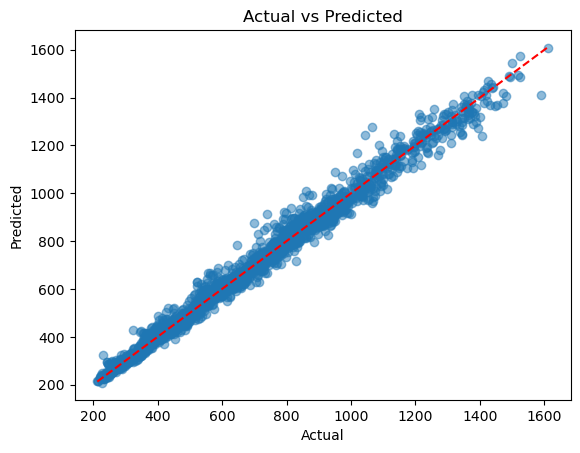

In [12]:
# KODE PENDUKUNG SOAL NOMOR 2
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_pred)))
print("R2 Score:", r2_score(y_val, val_pred))

plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

JAWABAN SOAL NOMOR 2: Hasil dari kode diatas menunjukkan bahwa Train RMSE=22.82, Validation RMSE=32.29, dan R²=0.9877. Kita tidak yakin ini Overfit atau Underfit, tapi dilihat dari nilai Train dan Validation yang relatif kecil dan R² yang sangat tinggi. Jadi kesimpulan terakhir kita, model yang kita buat tidak Overfit dan juga tidak Underfit.

----------------------------------------------------------------------------------------------------------------------------------------------------------

SOAL NOMOR 3: Apakah ada pola temporal berulang yang terlihat dari konsumsi listrik? Kira-kira
dataset ini berasal dari negara/wilayah dengan iklim seperti apa? Jelaskan reasoning
Anda berdasarkan pola musiman yang terlihat!

<Axes: xlabel='month'>

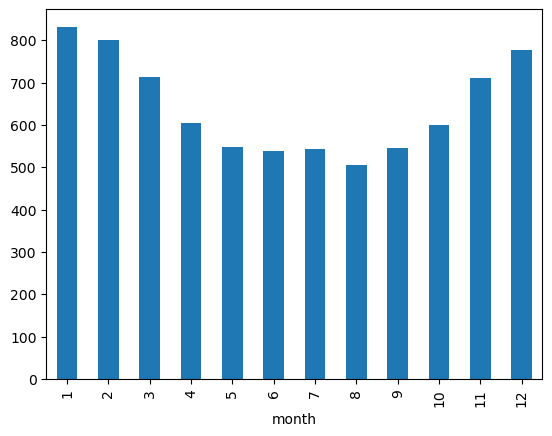

In [13]:
train['date'] = pd.to_datetime({'year': 2022, 'month': train['month'], 'day': train['dayofweek'] + 1})
train['month'] = pd.to_datetime(train['date']).dt.month
train.groupby('month')['electricity_consumption'].mean().plot(kind='bar')

In [24]:
train['temperature_2m_max'].describe()

count    11688.000000
mean        18.733385
std          7.504161
min         -1.900000
25%         12.800000
50%         18.200000
75%         24.300000
max         40.900000
Name: temperature_2m_max, dtype: float64

In [23]:
train['temperature_2m_min'].describe()

count    11688.000000
mean         7.174786
std          5.960263
min        -10.800000
25%          2.500000
50%          7.100000
75%         12.100000
max         23.200000
Name: temperature_2m_min, dtype: float64

JAWABAN NOMOR 3: Pertama, dari hasil visualisasi, kita mendapatkan bahwa ada lonjakan konsumsi listrik pada bulan januari dan desember, ini kemungkinan menandakan bahwa adanya penggunaan heater (pemanas ruangan) dan lampu. Penggunaan heater digunakan pada negara iklim sub-tropis pada musim salju, dan puncak musim salju juga mengurangi pencahayaan, akhirnya penggunaan lampu sangat tinggi. Kedua, melihat dari rata-rata data tempratur, suhu maksimum bisa serendah -1,9 celcius dan setinggi 40 Celcius, ini adalah suhu dari iklim sub-tropis yang memiliki suhu dingin dan panas yang kontras.

-----------------------------------------------------------------------------------------------------------------------------------------------------------

SOAL NOMOR 5 A: Berapa konsumsi listrik rata-rata dari tiap cluster saat suhu minimum di bawah
persentil 25 dan durasi sinar matahari di bawah rata-rata? Apa Insight yang
bisa didapat dari hal ini?

In [29]:
q1_temp = train['temperature_2m_min'].quantile(0.25)
avg_sunshine = train['sunshine_duration'].mean()

filtered = train[
    (train['temperature_2m_min'] < q1_temp) &
    (train['sunshine_duration'] < avg_sunshine)
]

mean_consumption = filtered.groupby('cluster_id')['electricity_consumption'].mean().reset_index()
mean_consumption.columns = ['Cluster', 'Mean Electricity Consumption (GWh)']
mean_consumption

,Cluster,Mean Electricity Consumption (GWh)
0,0,446.717842
1,1,656.699589
2,2,887.137849
3,3,1290.826150


JAWABAN NOMOR 5 A: Saat suhu minimum di bawah persentil 25 dan durasi sinar matahari di bawah rata-rata, konsumsi listrik rata-rata meningkat tajam di semua cluster, dengan Cluster 3 mencapai puncak penggunaan. Ini menunjukkan bahwa kondisi cuaca ekstrem (dingin dan gelap) sangat berdampak pada konsumsi energi, terutama di wilayah padat atau industri. Insight ini penting untuk perencanaan kapasitas energi, manajemen risiko beban puncak, dan efisiensi distribusi listrik berdasarkan segmentasi wilayah (cluster).

SOAL NOMOR 5 B: Apakah ada kombinasi cluster dan periode waktu tertentu yang memiliki
konsumsi listrik yang dapat dianggap outlier? Jelaskan justifikasi Anda.

In [34]:
train['date'] = pd.to_datetime(train['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

# Menggunakan IQR
outliers = train[train['is_outlier']]
Q1 = train['electricity_consumption'].quantile(0.25)
Q3 = train['electricity_consumption'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

train['is_outlier'] = train['electricity_consumption'] > upper_bound

outliers = train[train['is_outlier']]
outlier_summary = outliers.groupby(['cluster_id', 'year', 'month'])['electricity_consumption'].mean().reset_index()
outlier_summary

,cluster_id,year,month,electricity_consumption
0,3,2022,1,1526.902310
1,3,2022,2,1527.049857
2,3,2022,3,1530.378500
3,3,2022,12,1472.495000


JAWABAN SOAL 5 B: Ya, terdapat kombinasi cluster 3 dan periode Januari, Februari, Maret, serta Desember 2022 yang dapat dianggap outlier dalam konsumsi listrik. Nilai konsumsi yang melebihi 1500 GWh secara konsisten jauh di atas rata-rata nasional dan terlihat menonjol dalam distribusi data. Kemungkinan besar ini disebabkan oleh musim dingin dan karakteristik regional dari cluster tersebut (misalnya wilayah perkotaan besar atau pusat industri), yang memicu lonjakan kebutuhan energi. Dalam modeling, outlier seperti ini perlu diperhatikan karena bisa mempengaruhi performa model jika tidak ditangani secara eksplisit, misalnya dengan pendekatan robust modeling atau segmentasi berdasarkan musim/cluster.